In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm


import math
import itertools
import imageio
import natsort
from glob import glob


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE=128

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=False):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None
  
    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'
  
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28,28), cmap='Greys')
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)

In [ ]:
nc = 1
nz = 100
ngf = 32
ndf = 32
num_test_samples = 16


# Define Discriminator and Generator architectures
netG = Generator(nc, nz, ngf).to(device).float()
netD = Discriminator(nc, ndf).to(device).float()



# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

# initialize other variables
real_label = 1
fake_label = 0
num_batches = len(train_loader)
fixed_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)


Epoch [1/20], step [100/469], d_loss: 0.0600, g_loss: 5.0176, D(x): 0.97, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.01
Epoch [1/20], step [200/469], d_loss: 0.0253, g_loss: 5.1835, D(x): 0.99, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.01
Epoch [1/20], step [300/469], d_loss: 0.0393, g_loss: 5.0236, D(x): 0.98, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.01
Epoch [1/20], step [400/469], d_loss: 0.0157, g_loss: 6.4771, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [2/20], step [100/469], d_loss: 0.0135, g_loss: 6.6433, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/20], step [200/469], d_loss: 0.0242, g_loss: 6.6541, D(x): 1.00, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.00
Epoch [2/20], step [300/469], d_loss: 0.0191, g_loss: 5.9836, D(x): 1.00, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.01
Epoch [2/20], step [400/469], d_loss: 0.0218, g_loss: 6.7366, D(x): 0.99, Discrimin

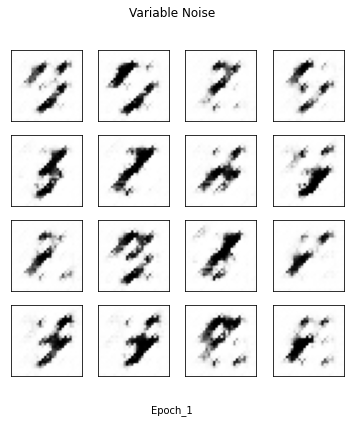

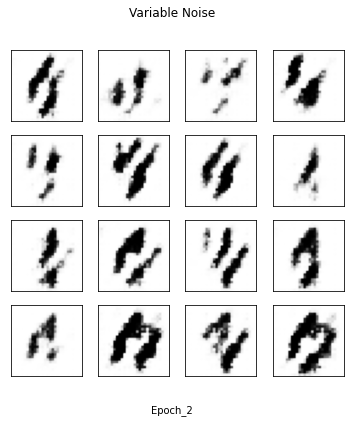

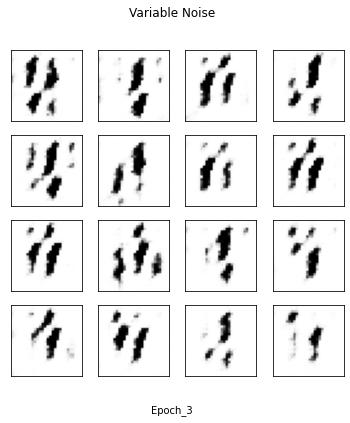

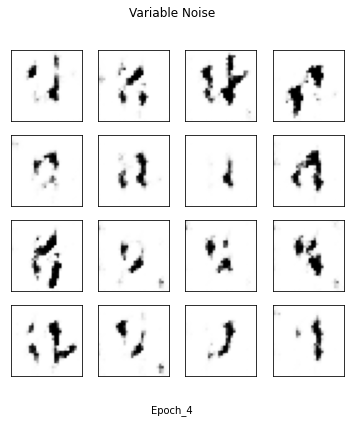

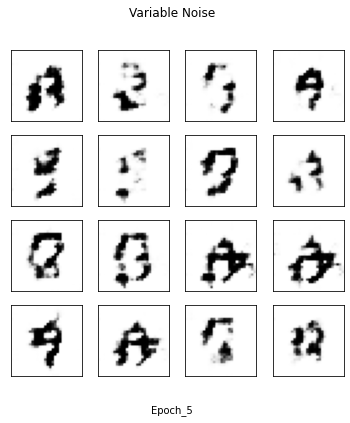

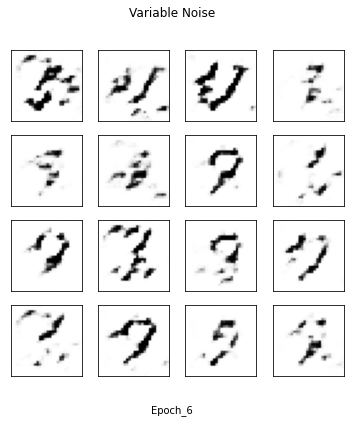

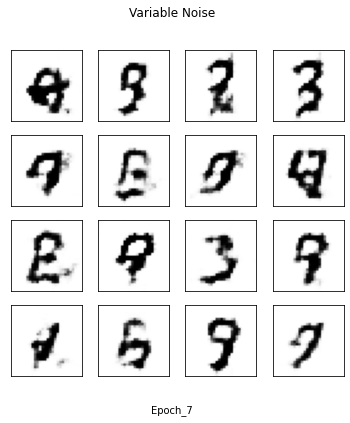

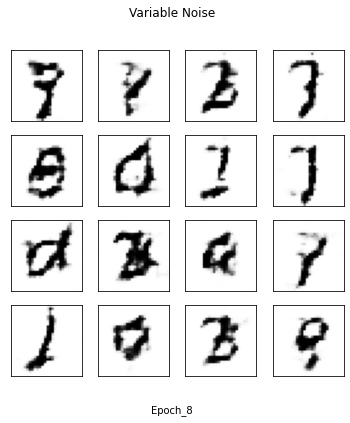

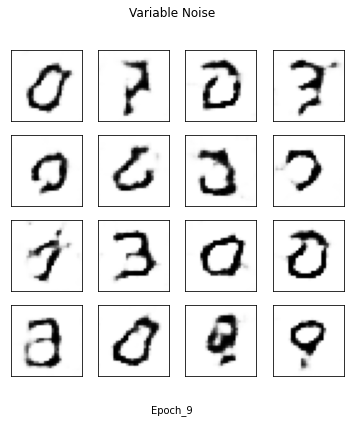

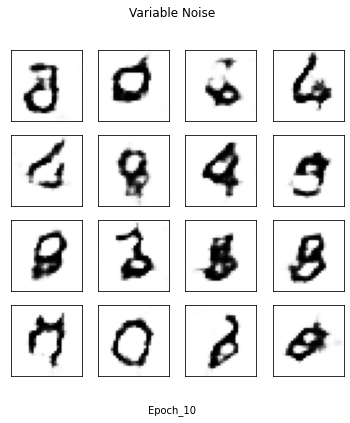

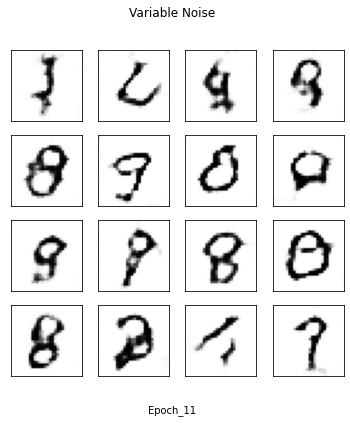

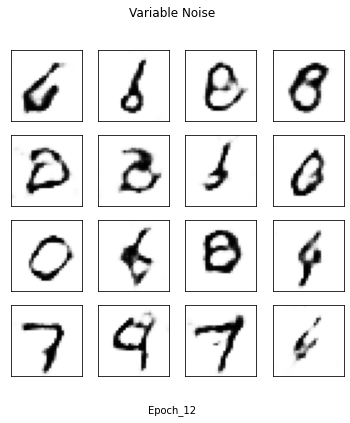

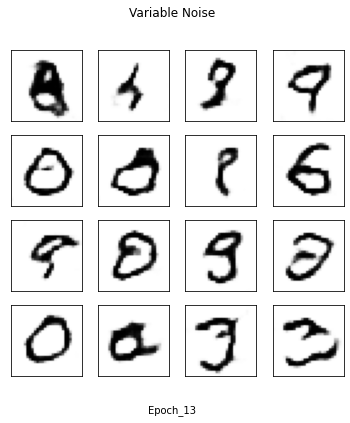

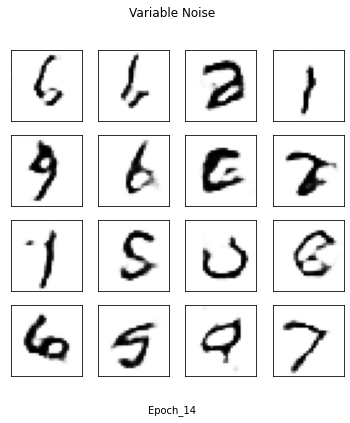

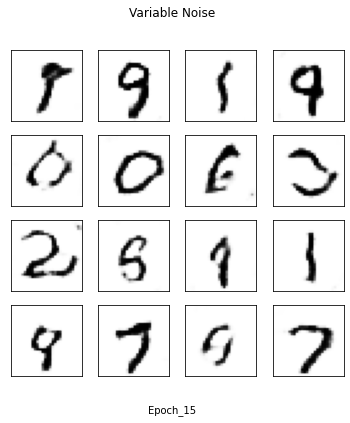

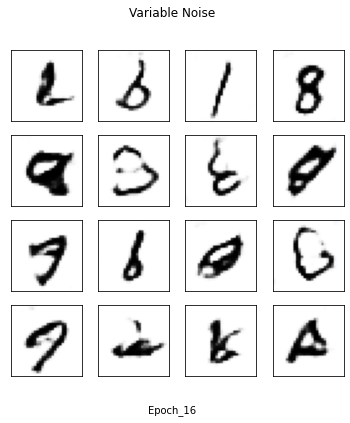

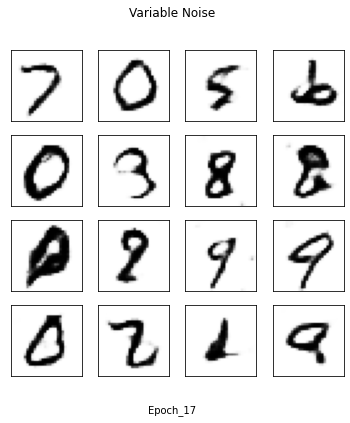

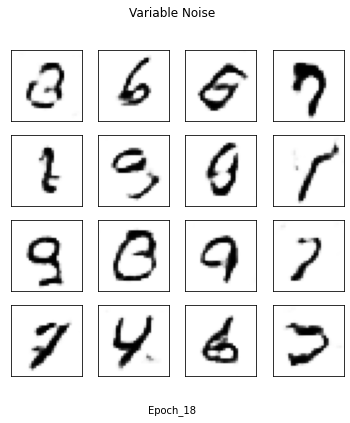

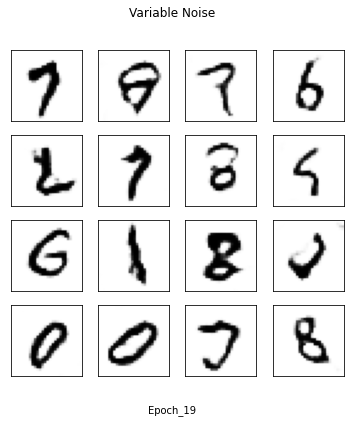

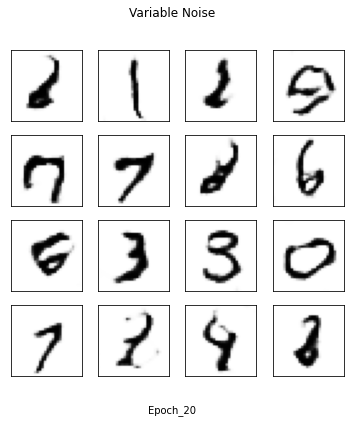

In [ ]:
num_epochs = 20
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        bs = real_images.shape[0]
        ##############################
        #   Training discriminator   #
        ##############################

        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)

        output = netD(real_images)
        lossD_real = criterion(output, label.float())
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label.float())
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        d_losses.append(lossD)
        optimizerD.step()

        ##########################
        #   Training generator   #
        ##########################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output, label.float())
        lossG.backward()
        g_losses.append(lossG)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i+1)%100 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'.format(epoch+1, num_epochs, 
    
                                                        i+1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    netG.eval()
    generate_images(epoch, './results/', fixed_noise, num_test_samples, netG, device, use_fixed=False)
    netG.train()


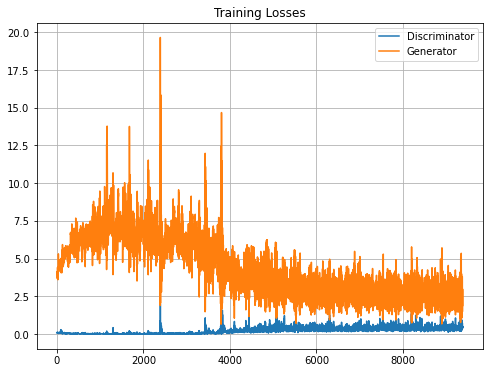

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title("Training Losses")
plt.grid()
plt.legend()